# Cartoonize Image by Style Transfer

## Import libraries

In [13]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24,24)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools
import time

## Image Utils

In [14]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

## Content image and Style application

In [15]:
image_links = [
    "https://scontent.xx.fbcdn.net/v/t1.15752-0/p180x540/158437160_240379114477751_4224753091836823568_n.jpg?_nc_cat=101&ccb=1-3&_nc_sid=f79d6e&_nc_ohc=GKh4DsQjXz8AX-gIzzr&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&tp=6&oh=f9aa960e5e4e3e4c2eddc02dfbb7e0d1&oe=606E060B",
    "https://cdn2.stylecraze.com/wp-content/uploads/2013/06/nanako-matsushima.jpg",
    "https://i.pinimg.com/564x/fc/48/af/fc48af3dc61155d0382f5d095694c585.jpg",
    "https://i.pinimg.com/originals/bf/17/05/bf170507466915c157bed4fbd6c59a78.jpg",
    "https://nypost.com/wp-content/uploads/sites/2/2020/12/yael-most-beautiful-video.jpg",
    "https://s.yimg.com/ny/api/res/1.2/6fh8dX7HxCqWj0fCxMIKfQ--/YXBwaWQ9aGlnaGxhbmRlcjtoPTY2Ng--/https://s.yimg.com/cd/resizer/2.0/original/-Q7ql8v_Hy83ubHz_N1KOxjFLbo",
    "https://i.pinimg.com/564x/57/14/96/571496d0e562669c7e3b39373cc3b4af.jpg"
]

style_links = [
    "https://blogphotoshop.com/wp-content/uploads/2019/03/nhung-hinh-anh-anime-nu-dep-nhat-2.jpg",
    "https://i.pinimg.com/originals/79/b5/da/79b5da63f1c2cb9ce94e3801621ebb60.png",
    # "https://i.pinimg.com/736x/2c/cc/25/2ccc2516f0e795a1f504ce54872c4f73.jpg",
    # "https://media.overstockart.com/optimized/cache/data/product_images/VG485-1000x1000.jpg",
    # "https://i.pinimg.com/originals/88/8a/a9/888aa921251ebd4de7a4833b715dee33.jpg",
    # "https://i.pinimg.com/originals/8e/f8/0c/8ef80cdca4b6469c34e2645177c65929.jpg"
]

In [16]:
content_images = []
style_images = []

for index, link in enumerate(image_links):
    path = tf.keras.utils.get_file('girl' + '_' + str(index) + '.jpg', link)
    content_images.append(load_img(path))

for index, link in enumerate(style_links):
    path = tf.keras.utils.get_file('style' + '_' + str(index) + '.jpg', link)
    style_images.append(load_img(path))

## Content and Style Image Preview

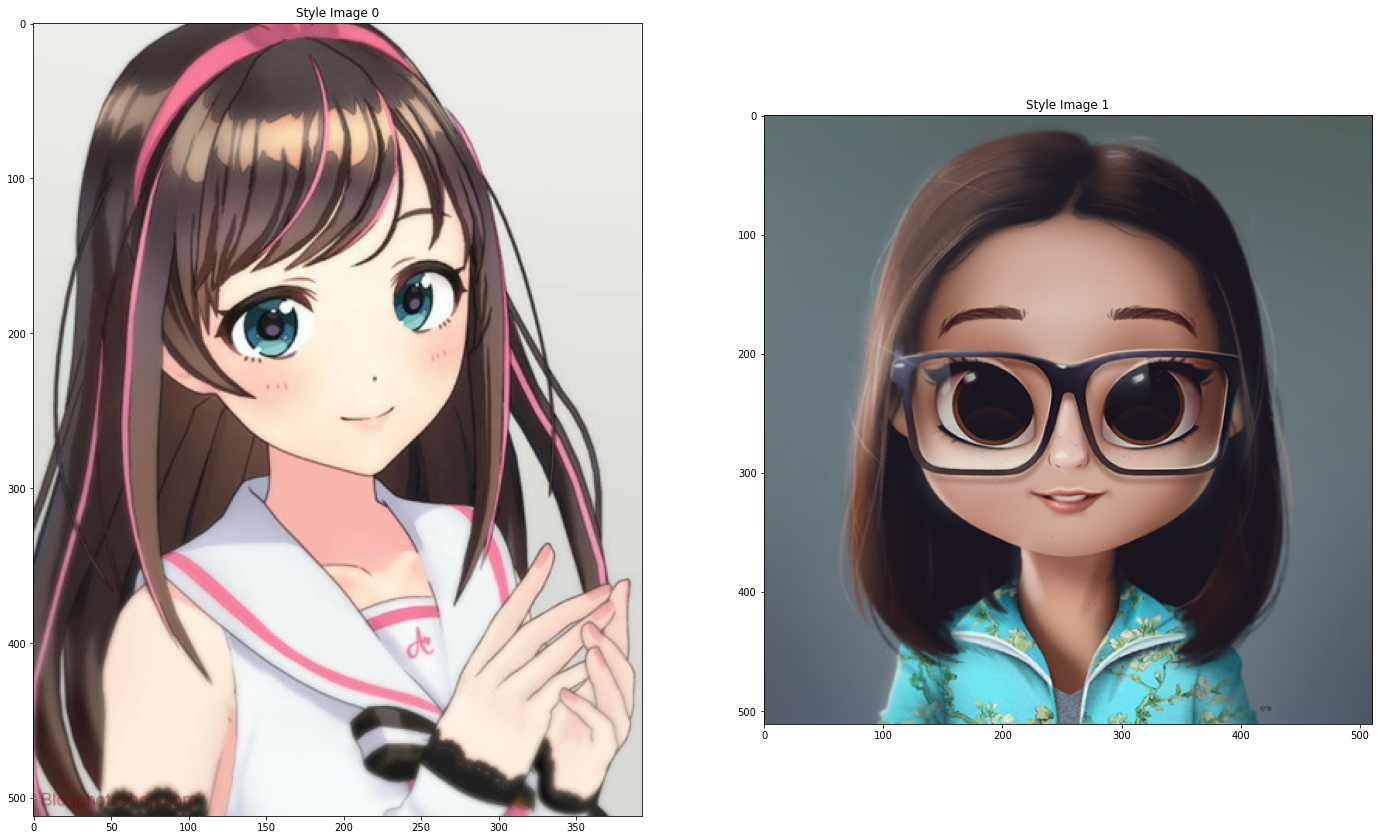

In [17]:
for i in range(len(style_links)):
    plt.subplot(1, len(style_links), i + 1)
    imshow(style_images[i], 'Style Image ' + str(i))


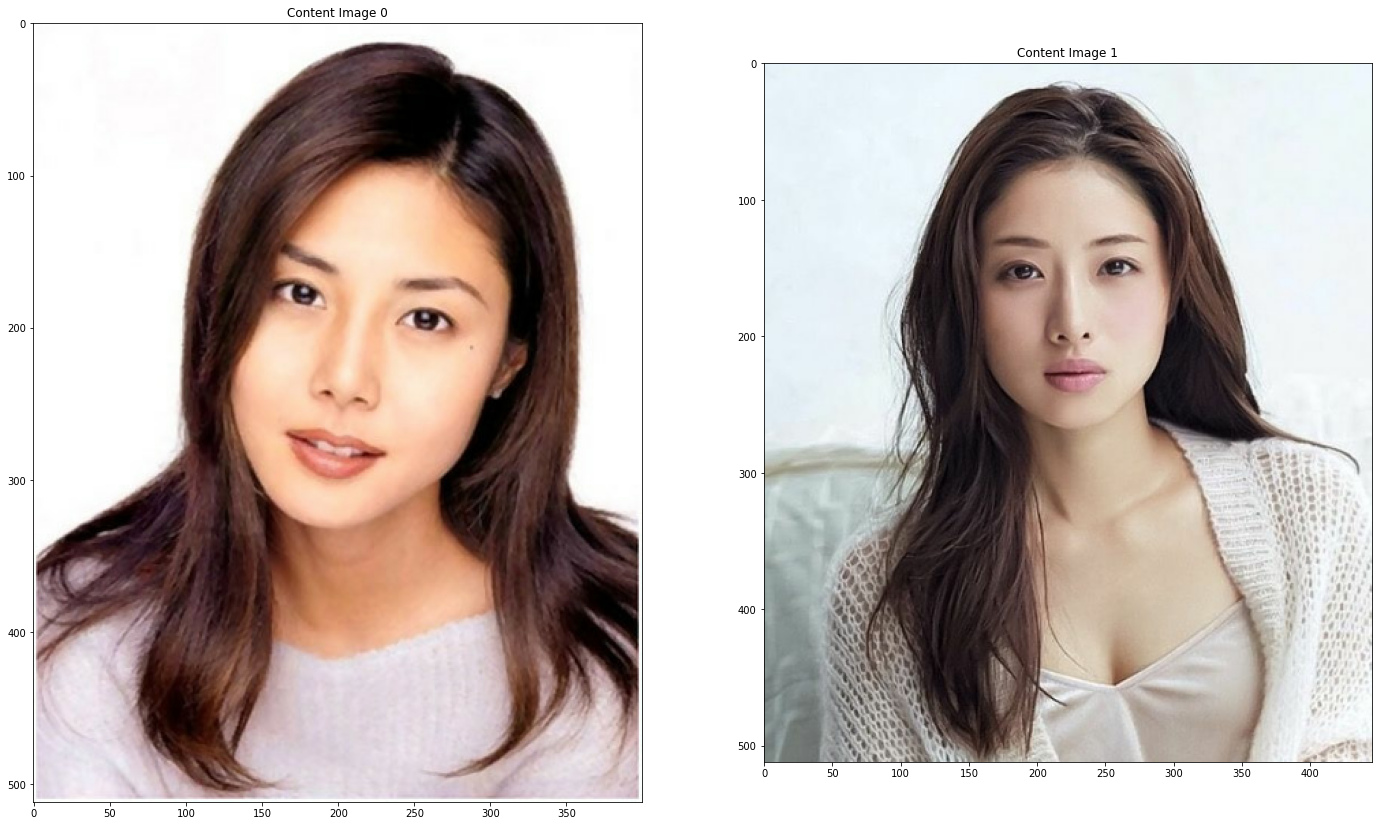

In [18]:
for i in range(len(image_links)):
    plt.subplot(1, len(image_links), i + 1)
    imshow(content_images[i], 'Content Image ' + str(i))

## Model

In [19]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, model, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(model, style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                        outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [20]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Model Utils

In [21]:
def vgg_layers(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

class Custom_Train(object):
    def __init__(self, image, optimizer, targets, loss_weight):
        self._image = image
        self._optimizer = optimizer
        self._targets = targets
        self._loss_Weight = loss_weight

    def __call__(self):
        with tf.GradientTape() as tape:
            outputs = extractor(self._image)
            loss = style_content_loss(
                outputs,  
                style_targets   = self._targets[0],
                content_targets = self._targets[1],
                style_weight    = self._loss_Weight[0], 
                content_weight  = self._loss_Weight[1]
            ) + total_variation_weight * tf.image.total_variation(image)

        grad = tape.gradient(loss, self._image)
        optimizer.apply_gradients([(grad, self._image)])
        self._image.assign(clip_0_1(self._image))

def image_style_tranfer(image, train_parameters, epochs = 10, steps_per_epoch = 100):
    start = time.time()
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step = Custom_Train(
                image,
                train_parameters['optimizer'],
                train_parameters['targets'],
                train_parameters['loss_weight']
            )
            train_step()
            print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

## Load VGG Model & Create Extractor

In [22]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
style_extractor = vgg_layers(vgg, style_layers)
extractor = StyleContentModel(vgg, style_layers, content_layers)

## Style Transfering

In [26]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=0.001
content_weight=1000
total_variation_weight=30

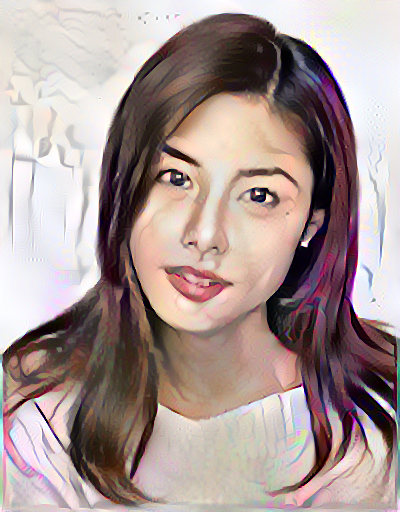

Train step: 300
....................................................................................................

In [ ]:
import copy

result_images = []
for style_image in style_images:
    style_targets = extractor(style_image)['style']
    for content_image in content_images:
        image = tf.Variable(content_image)
        content_targets = extractor(content_image)['content']
        train_parameters = {
            'optimizer'     : optimizer,
            'loss_weight'   : (style_weight, content_weight, total_variation_weight),
            'targets'       : (style_targets, content_targets)
        }
        image_style_tranfer(image, train_parameters, epochs=5)
        result_images.append(copy.deepcopy(image))

## The result

In [ ]:
for index, result_image in enumerate(result_images):
    imshow(result_image, 'Result Image ' + str(index + 1))